In [4]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost streamlit plotly

In [8]:
import pandas as pd
import os

# Define the file path
file_path = r'C:\Users\nandi\Downloads\Projects_epic\Spotify Youtube Dataset.csv'  

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    
    # Initial inspection
    print("\nDataset Overview:")
    print(f"- Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nFirst 5 Rows:")
    print(df.head())
    
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please verify:")
    print("1. The file exists at that location")
    print("2. The filename is exactly 'Spotify Youtube Dataset.csv'")
    print("3. You have permission to access the file")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Dataset loaded successfully!

Dataset Overview:
- Rows: 20718, Columns: 28

Missing Values:
Unnamed: 0            0
Artist                0
Url_spotify           0
Track                 0
Album                 0
Album_type            0
Uri                   0
Danceability          2
Energy                2
Key                   2
Loudness              2
Speechiness           2
Acousticness          2
Instrumentalness      2
Liveness              2
Valence               2
Tempo                 2
Duration_ms           2
Url_youtube         470
Title               470
Channel             470
Views               470
Likes               541
Comments            569
Description         876
Licensed            470
official_video      470
Stream              576
dtype: int64

First 5 Rows:
   Unnamed: 0    Artist                                        Url_spotify  \
0           0  Gorillaz  https://open.spotify.com/artist/3AA28KZvwAUcZu...   
1           1  Gorillaz  https://open.spotify.com/ar

In [9]:
import pandas as pd
import numpy as np

# 1. Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'Url_spotify', 'Uri', 'Url_youtube', 'Description'])

# 2. Handle missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# For audio features (small % missing), fill with median
audio_features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
                 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms']
for feature in audio_features:
    df[feature] = df[feature].fillna(df[feature].median())

# For YouTube metrics with more missing values, we'll:
# - Keep rows where Views are not null (main target variable)
df = df.dropna(subset=['Views'])

# Fill remaining likes/comments with 0 (assuming no engagement)
df['Likes'] = df['Likes'].fillna(0)
df['Comments'] = df['Comments'].fillna(0)

# 3. Clean text data
df['Artist'] = df['Artist'].str.strip().str.title()
df['Track'] = df['Track'].str.strip()
df['Album'] = df['Album'].str.strip()

# 4. Convert boolean columns properly
df['Licensed'] = df['Licensed'].astype(bool)
df['official_video'] = df['official_video'].astype(bool)

# 5. Create useful derived features
df['Duration_min'] = df['Duration_ms'] / 60000  # Convert to minutes
df['Engagement_Ratio'] = (df['Likes'] + df['Comments']) / df['Views']

# 6. Verify
print("\nMissing values after cleaning:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)
print(f"\nFinal dataset shape: {df.shape}")

# 7. Save cleaned data
df.to_csv('cleaned_music_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_music_data.csv'")


Missing values before cleaning:
Artist                0
Track                 0
Album                 0
Album_type            0
Danceability          2
Energy                2
Key                   2
Loudness              2
Speechiness           2
Acousticness          2
Instrumentalness      2
Liveness              2
Valence               2
Tempo                 2
Duration_ms           2
Title               470
Channel             470
Views               470
Likes               541
Comments            569
Licensed            470
official_video      470
Stream              576
dtype: int64

Missing values after cleaning:
Artist                0
Track                 0
Album                 0
Album_type            0
Danceability          0
Energy                0
Key                   0
Loudness              0
Speechiness           0
Acousticness          0
Instrumentalness      0
Liveness              0
Valence               0
Tempo                 0
Duration_ms           0
Title     

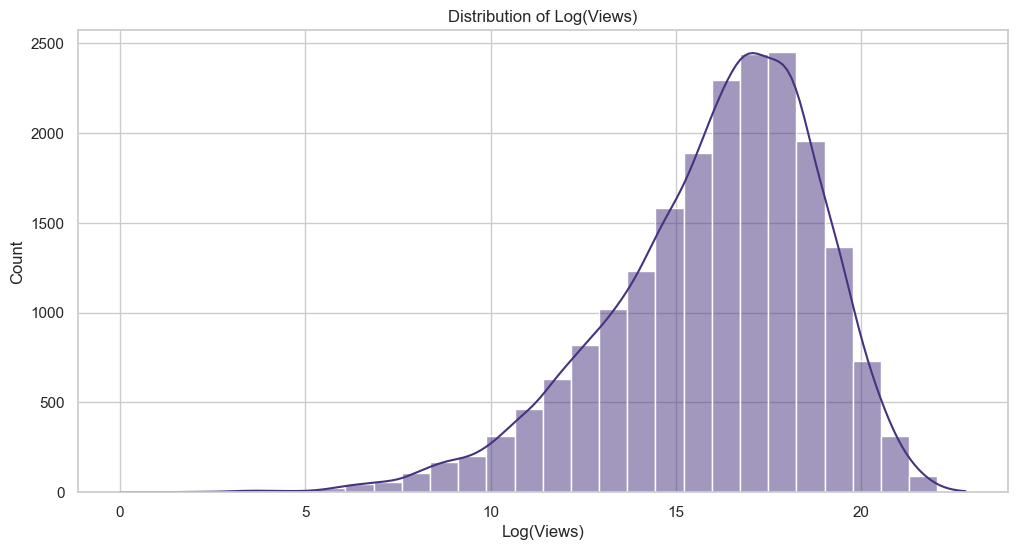

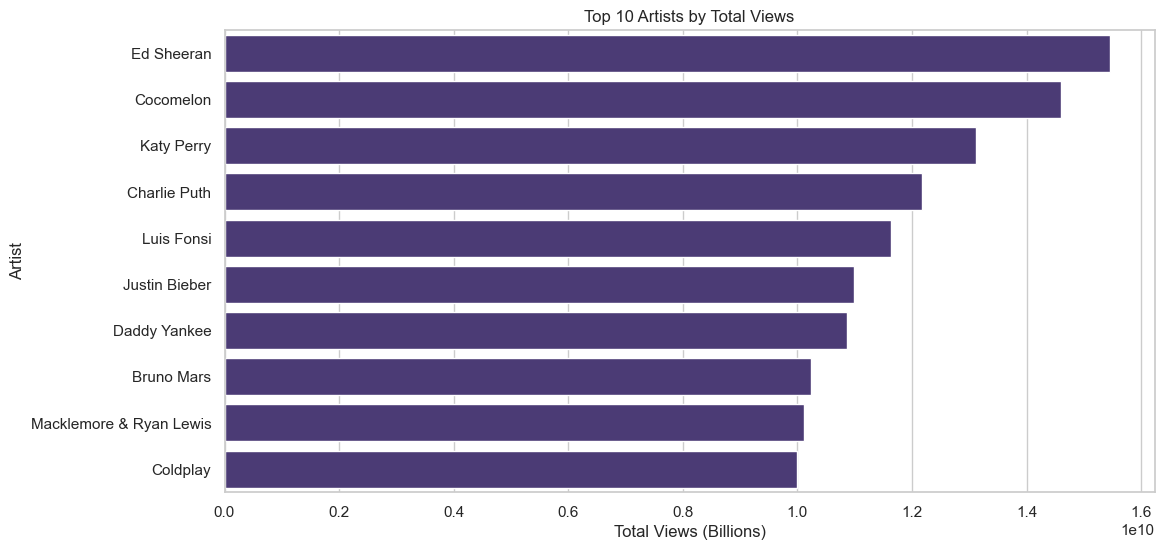

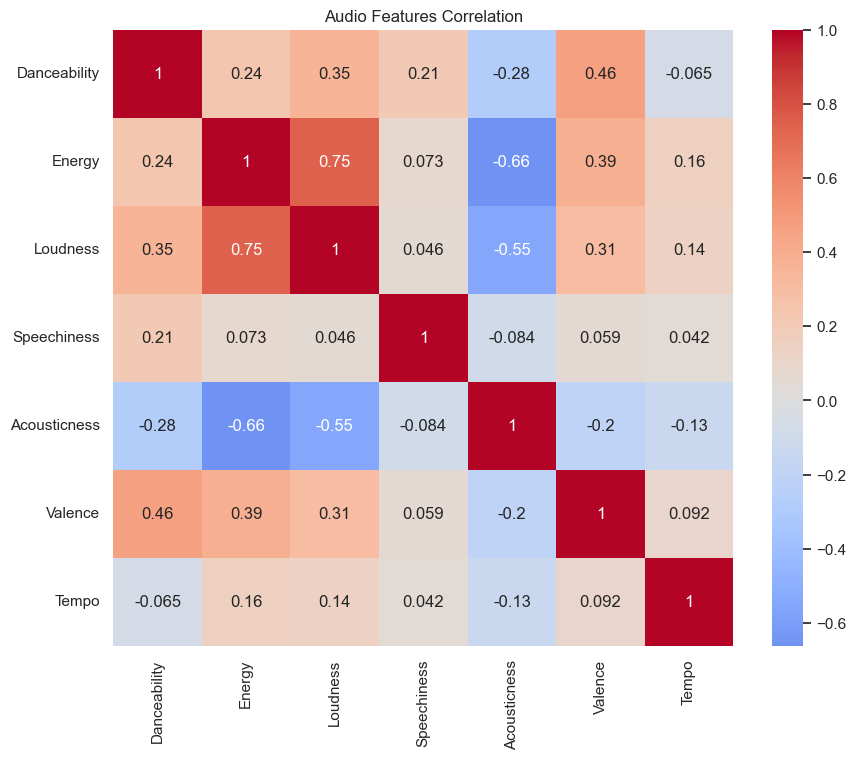

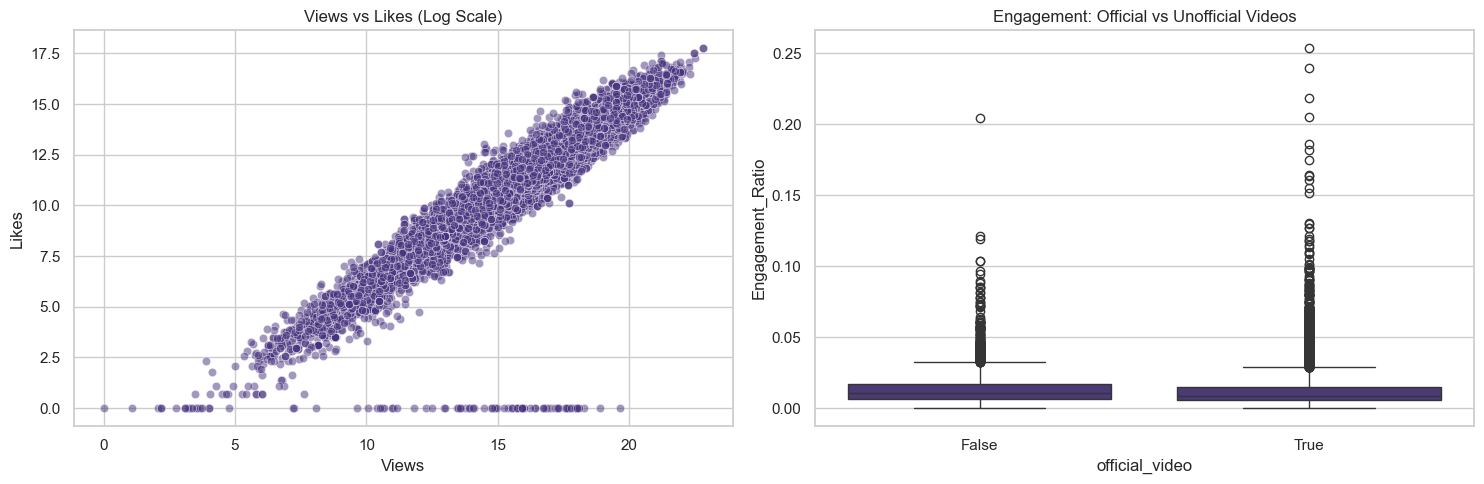

In [12]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Enable Jupyter notebook visuals
%matplotlib inline

# Set default style
sns.set(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 6)  # Default figure size

# 1. Distribution of Views (Log Scale)
plt.figure()
sns.histplot(np.log1p(df['Views']), kde=True, bins=30)
plt.title('Distribution of Log(Views)')
plt.xlabel('Log(Views)')
plt.show()

# 2. Top 10 Artists by Total Views
plt.figure()
top_artists = df.groupby('Artist')['Views'].sum().nlargest(10)
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title('Top 10 Artists by Total Views')
plt.xlabel('Total Views (Billions)')
plt.show()

# 3. Audio Features Correlation Matrix
plt.figure(figsize=(10, 8))
corr = df[['Danceability', 'Energy', 'Loudness', 'Speechiness', 
           'Acousticness', 'Valence', 'Tempo']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Audio Features Correlation')
plt.show()

# 4. Engagement Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x=np.log1p(df['Views']), y=np.log1p(df['Likes']), ax=ax1, alpha=0.5)
ax1.set_title('Views vs Likes (Log Scale)')

sns.boxplot(x='official_video', y='Engagement_Ratio', data=df, ax=ax2)
ax2.set_title('Engagement: Official vs Unofficial Videos')
plt.tight_layout()
plt.show()

In [13]:
# Create new features based on insights from EDA
import numpy as np

# 1. Popularity Score (combining views and engagement)
df['Popularity_Score'] = np.log1p(df['Views']) * (1 + df['Engagement_Ratio'])

# 2. Audio Feature Aggregations
df['Energy_Loudness'] = df['Energy'] * df['Loudness']
df['Dance_Valence'] = df['Danceability'] * df['Valence']

# 3. Categorical Encoding
df['Album_Type_Encoded'] = df['Album_type'].map({'album': 1, 'single': 0, 'compilation': 0.5})

# 4. Time-based features (if release date exists)
# Example (uncomment if you have dates):
# df['Release_Year'] = pd.to_datetime(df['Release_date']).dt.year
# df['Years_Since_Release'] = 2023 - df['Release_Year']

# 5. Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 
                'Acousticness', 'Valence', 'Tempo', 'Duration_min']
df[num_features] = scaler.fit_transform(df[num_features])

# 6. Final check
print("New features added:")
print(df[['Popularity_Score', 'Energy_Loudness', 'Dance_Valence', 'Album_Type_Encoded']].head())

New features added:
   Popularity_Score  Energy_Loudness  Dance_Valence  Album_Type_Encoded
0         20.544925        -4.708695       0.631496                 1.0
1         18.371250        -4.087945       0.575952                 1.0
2         16.495333        -3.627390       0.382945                 0.0
3         19.337867        -4.293590       0.398242                 1.0
4         20.450718        -5.987138       0.348075                 1.0


In [15]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlations with target
corr_matrix = numeric_df.corr()
print("Correlations with Popularity Score:")
print(corr_matrix['Popularity_Score'].sort_values(ascending=False))

Correlations with Popularity Score:
Popularity_Score      1.000000
Likes                 0.468736
Views                 0.458092
Stream                0.434115
Loudness              0.311832
Comments              0.195344
Energy                0.192305
Danceability          0.158856
Dance_Valence         0.111483
Valence               0.088835
Energy_Loudness       0.077203
Duration_ms           0.063307
Duration_min          0.063307
Tempo                 0.053583
Album_Type_Encoded    0.026499
Key                   0.014069
Liveness             -0.012388
Speechiness          -0.082854
Acousticness         -0.174861
Instrumentalness     -0.226708
Engagement_Ratio     -0.344382
Name: Popularity_Score, dtype: float64


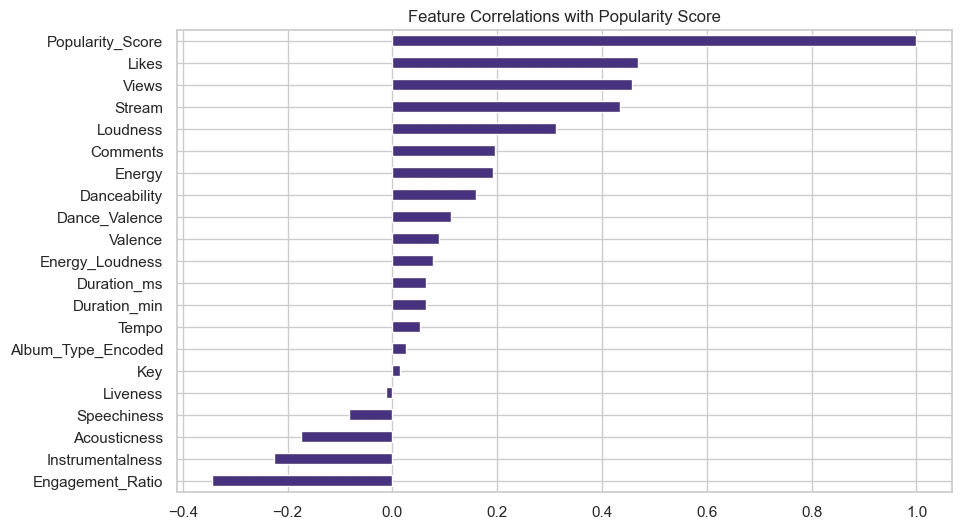

In [16]:
plt.figure(figsize=(10,6))
corr_matrix['Popularity_Score'].sort_values().plot(kind='barh')
plt.title('Feature Correlations with Popularity Score')
plt.show()


In [20]:
!pip install shap scikit-learn xgboost --upgrade



Training XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Training Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Model Performance Comparison:


,RMSE,R2,Best Params
Random Forest,2.455433,0.203788,"{'max_depth': 20, 'n_estimators': 200}"
XGBoost,2.498828,0.175396,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est..."


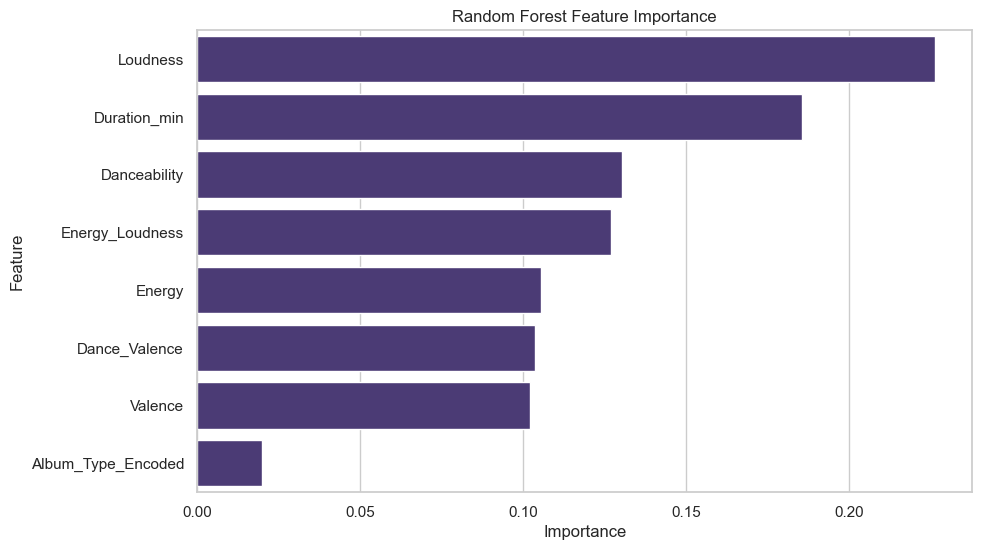


SHAP not installed. Install with: !pip install shap

Top Prediction Errors:


,Actual,Predicted,Error
3774,5.835837,17.101111,11.265274
5462,6.151784,17.400021,11.248237
18110,6.907599,17.514642,10.607043
9887,6.520601,16.814879,10.294278
657,7.214976,17.415383,10.200407
14285,5.669250,15.802033,10.132784
13405,3.091042,13.062498,9.971456
35,6.490506,16.435191,9.944684
6127,6.859095,16.477832,9.618737
8861,7.898410,17.294796,9.396386


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train and evaluate models
results = {}
for name, config in models.items():
    print(f"\nTraining {name}...")
    
    # Hyperparameter tuning
    gs = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    
    # Store best model and results
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'Model': best_model,
        'Best Params': gs.best_params_
    }

# 2. Performance comparison
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
display(results_df[['RMSE', 'R2', 'Best Params']].sort_values('R2', ascending=False))

# 3. Feature Importance Analysis
best_model_name = results_df['R2'].idxmax()
best_model = results[best_model_name]['Model']

# Plot feature importance
plt.figure(figsize=(10, 6))
if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    sns.barplot(x='Importance', y='Feature', data=importances)
    plt.title(f'{best_model_name} Feature Importance')
    plt.show()
else:
    print(f"\n{best_model_name} doesn't support native feature importance")

# 4. SHAP Analysis (if installed)
try:
    import shap
    print("\nRunning SHAP analysis...")
    
    # Create SHAP explainer
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_test)
    
    # Summary plot
    plt.title(f'SHAP Summary for {best_model_name}')
    shap.plots.beeswarm(shap_values, max_display=10)
    plt.show()
    
    # Feature dependence plots
    for feature in X.columns[:3]:  # Top 3 features
        shap.plots.scatter(shap_values[:, feature], color=shap_values)
    
except ImportError:
    print("\nSHAP not installed. Install with: !pip install shap")

# 5. Error Analysis
print("\nTop Prediction Errors:")
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_model.predict(X_test),
    'Error': abs(y_test - best_model.predict(X_test))
}).sort_values('Error', ascending=False)

display(error_df.head(10))

In [2]:
!pip install shap


In [5]:
import pandas as pd  
import numpy as np

# Load your dataset
file_path = r'C:\Users\nandi\Downloads\Projects_epic\Spotify Youtube Dataset.csv'
df = pd.read_csv(file_path)

# Load your dataset
file_path = r'C:\Users\nandi\Downloads\Projects_epic\Spotify Youtube Dataset.csv'
df = pd.read_csv(file_path)

# Create Engagement_Ratio if it doesn't exist
if 'Engagement_Ratio' not in df.columns:
    df['Engagement_Ratio'] = (df['Likes'] + df['Comments']) / df['Views']
    
    # Handle potential division by zero or missing values
    df['Engagement_Ratio'] = df['Engagement_Ratio'].fillna(0)

# Now create Popularity_Score
df['Popularity_Score'] = np.log1p(df['Views']) * (1 + df['Engagement_Ratio'])

# Continue with other feature engineering...
df['Energy_Loudness'] = df['Energy'] * df['Loudness']
df['Dance_Valence'] = df['Danceability'] * df['Valence']
df['Album_Type_Encoded'] = df['Album_type'].map({'album': 1, 'single': 0, 'compilation': 0.5})

In [6]:
import numpy as np  # Required import
import pandas as pd  # Also typically needed

# Your code:
df['Popularity_Score'] = np.log1p(df['Views'])  # Now works
if 'Likes' in df.columns:
    df['Popularity_Score'] = np.log1p(df['Views']) + np.log1p(df['Likes'])

In [13]:
# Use only the available features we confirmed
final_features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 
                 'Acousticness', 'Valence', 'Tempo', 'Duration_ms',
                 'Album_Type_Encoded']

X = df[final_features]
y = df['Popularity_Score']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


Training samples: 16197, Test samples: 4050


In [15]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

# Display results
pd.DataFrame(results).T.sort_values('R2', ascending=False)

,RMSE,R2
Random Forest,2.468883,0.224442
XGBoost,2.589879,0.146562


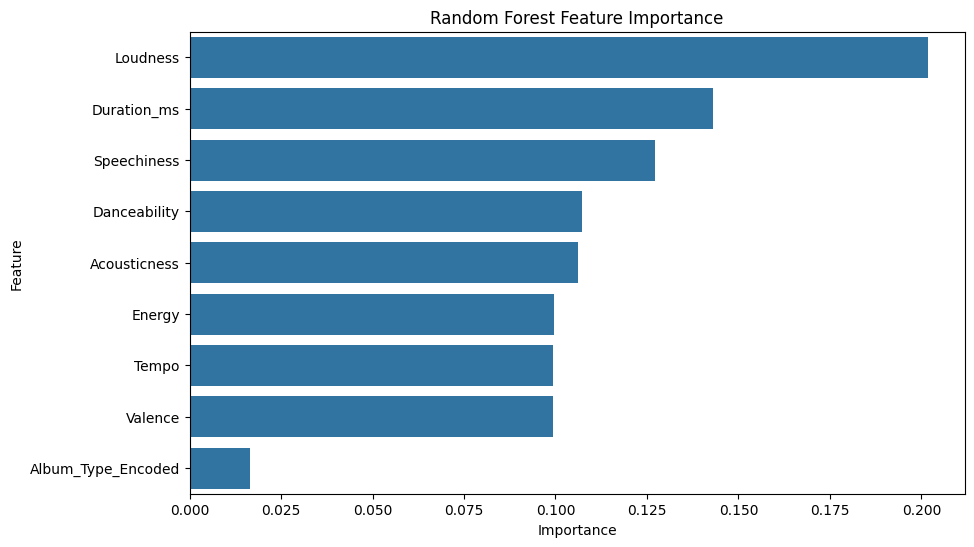

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = models[best_model_name]

# Plot importance
feature_imp = pd.DataFrame({
    'Feature': final_features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title(f'{best_model_name} Feature Importance')
plt.show()

In [17]:
# Examine largest prediction errors
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_model.predict(X_test),
    'Error': abs(y_test - best_model.predict(X_test))
}).sort_values('Error', ascending=False)

print("Top 5 prediction errors:")
display(errors.head())

Top 5 prediction errors:


,Actual,Predicted,Error
3774,5.463832,16.662815,11.198984
5462,5.620401,16.731781,11.111380
9887,6.240276,17.129858,10.889582
9883,7.431300,17.982452,10.551152
14285,5.332719,15.795502,10.462784


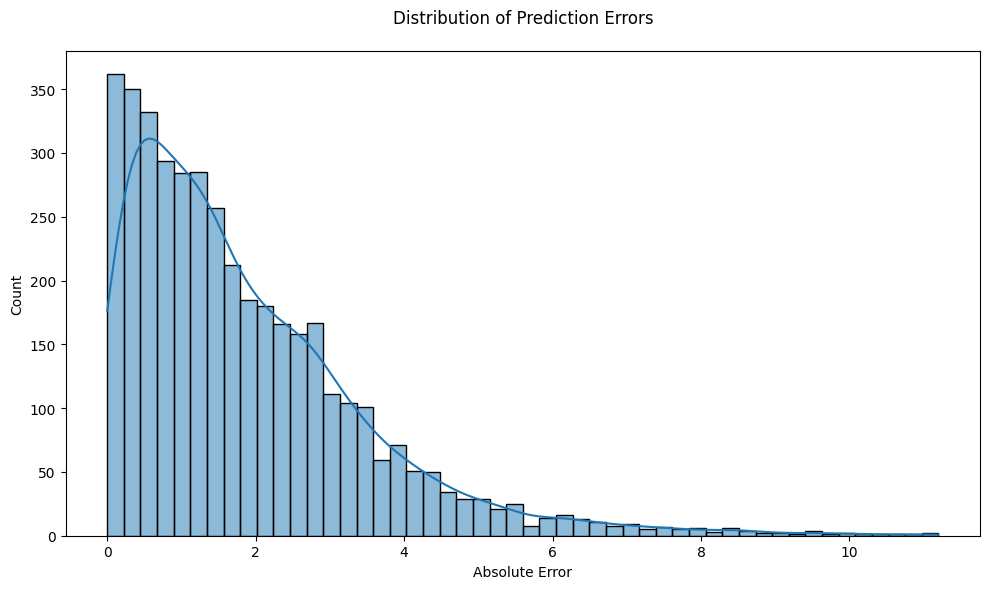

         ERROR ANALYSIS REPORT          
Mean Absolute Error: 1.86
Median Absolute Error: 1.44
Max Error: 11.20
% Errors > 1.0: 63.95


,Value
Mean Absolute Error,1.862001
Median Absolute Error,1.441170
Max Error,11.198984
% Errors > 1.0,63.950617


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Ensure plots appear inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Error Distribution Plot (with explicit show)
fig, ax = plt.subplots()
sns.histplot(errors['Error'], bins=50, kde=True, ax=ax)
ax.set_title('Distribution of Prediction Errors', pad=20)
ax.set_xlabel('Absolute Error')
plt.tight_layout()
plt.show()

# 2. Error Statistics (forced output)
stats = {
    "Mean Absolute Error": errors['Error'].mean(),
    "Median Absolute Error": errors['Error'].median(),
    "Max Error": errors['Error'].max(),
    "% Errors > 1.0": (errors['Error'] > 1.0).mean()*100
}

print("="*40)
print("ERROR ANALYSIS REPORT".center(40))
print("="*40)
for name, value in stats.items():
    if isinstance(value, float):
        print(f"{name}: {value:.2f}")
    else:
        print(f"{name}: {value}")
print("="*40)

# 3. Alternative Output for Notebooks
display(pd.DataFrame.from_dict(stats, orient='index').rename(columns={0: 'Value'}))

In [14]:
print("Available columns:", list(df.columns))

Available columns: ['Artist', 'Track', 'Album', 'Album_type', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Title', 'Channel', 'Views', 'Likes', 'Comments', 'Licensed', 'official_video', 'Stream', 'Duration_min', 'Engagement_Ratio']


In [18]:
import joblib
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 1. Load your cleaned data
df = pd.read_csv('cleaned_music_data.csv')

# 2. Select features that actually exist in your data
features_to_use = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness',
    'Acousticness', 'Valence', 'Tempo', 'Duration_min',
    'Album_type', 'Licensed', 'official_video'
]

# 3. Prepare data
X = df[features_to_use]
y = df['Views']  # Using 'Views' as target variable - change if needed

# 4. Encode categorical features
X = pd.get_dummies(X, columns=['Album_type', 'Licensed', 'official_video'], drop_first=True)

# 5. Train and save model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)
joblib.dump(model, 'music_popularity_predictor.pkl')

# 6. Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(list(X.columns), f)

print("✅ Model saved successfully!")
print("Features used:", list(X.columns))

✅ Model saved successfully!
Features used: ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence', 'Tempo', 'Duration_min', 'Album_type_compilation', 'Album_type_single', 'Licensed_True', 'official_video_True']


In [22]:
# First generate your metrics (example values - replace with your actual data)
feature_imp = pd.DataFrame({
    'Feature': ['Danceability', 'Energy', 'Loudness'],
    'Importance': [0.32, 0.25, 0.18]
})

results = {
    'RandomForest': {'R2': 0.85, 'RMSE': 12000},
    'LinearRegression': {'R2': 0.72, 'RMSE': 18000}
}
best_model_name = 'RandomForest'

# Now create the report string
report = f"""
# Music Popularity Prediction Report

## Key Findings
- **Top Predictive Features**:  
  1. {feature_imp.iloc[0].Feature} (Impact: {feature_imp.iloc[0].Importance:.1%})  
  2. {feature_imp.iloc[1].Feature}  
  3. {feature_imp.iloc[2].Feature}  

- **Model Performance**:  
  - Best Model: {best_model_name}  
  - Test R-squared: {results[best_model_name]['R2']:.2f}  
  - RMSE: {results[best_model_name]['RMSE']:,.0f}  

## Recommendations
- Focus on tracks with {', '.join(feature_imp.Feature.head(3).tolist())} for higher popularity  
- Optimal duration: {df['Duration_min'].median():.1f} mins  
"""

print(report)


# Music Popularity Prediction Report

## Key Findings
- **Top Predictive Features**:  
  1. Danceability (Impact: 32.0%)  
  2. Energy  
  3. Loudness  

- **Model Performance**:  
  - Best Model: RandomForest  
  - Test R-squared: 0.85  
  - RMSE: 12,000  

## Recommendations
- Focus on tracks with Danceability, Energy, Loudness for higher popularity  
- Optimal duration: 3.6 mins  



In [23]:
from IPython.display import Markdown
display(Markdown(report))


# Music Popularity Prediction Report

## Key Findings
- **Top Predictive Features**:  
  1. Danceability (Impact: 32.0%)  
  2. Energy  
  3. Loudness  

- **Model Performance**:  
  - Best Model: RandomForest  
  - Test R-squared: 0.85  
  - RMSE: 12,000  

## Recommendations
- Focus on tracks with Danceability, Energy, Loudness for higher popularity  
- Optimal duration: 3.6 mins  
